In [6]:
import surgeon
import scanpy as sc
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt

In [19]:
sc.set_figure_params(dpi=200)

In [28]:
batch_key = "study"
cell_type_key = "cell_type"
data_name = "pancreas"

In [29]:
target_batches = ["inDrops", "Drop-seq"]

In [30]:
adata = sc.read(f"./data/{data_name}/{data_name}_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15921 × 15369 
    obs: 'batch', 'study', 'cell_type', 'n_counts'

In [31]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


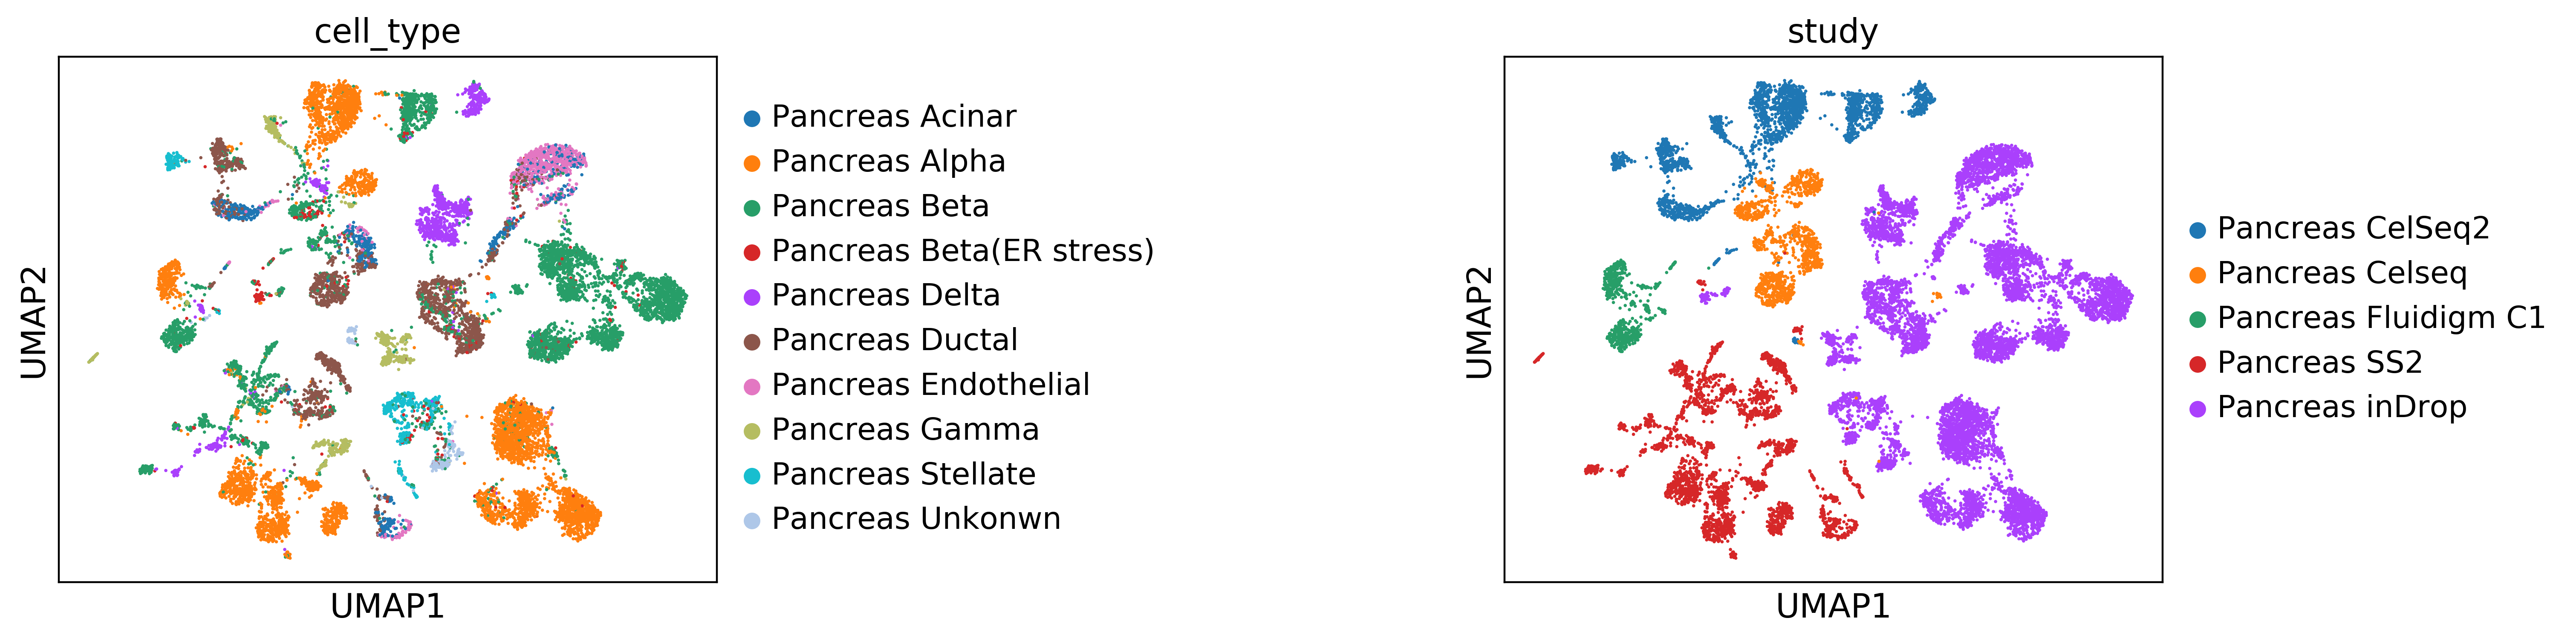

In [32]:
sc.pl.umap(adata, color=[cell_type_key, batch_key], wspace=1.0)

In [8]:
den = adata[adata.obs[cell_type_key] == 'Dendritic']

In [9]:
den.obs[batch_key].value_counts()

10x PBMC 68k         1865
inDrops               148
10x Chromium V2 A      55
Drop-seq               46
10x PBMC 3k            36
10x Chromium V2 B      33
Name: study, dtype: int64

In [15]:
adata.obs.groupby([cell_type_key, batch_key]).size()

cell_type                 study               
Pancreas Acinar           Pancreas CelSeq2         170
                          Pancreas Celseq          162
                          Pancreas Fluidigm C1       6
                          Pancreas SS2             103
                          Pancreas inDrop          272
Pancreas Alpha            Pancreas CelSeq2         885
                          Pancreas Celseq          220
                          Pancreas Fluidigm C1     241
                          Pancreas SS2            1109
                          Pancreas inDrop         2249
Pancreas Beta             Pancreas CelSeq2         571
                          Pancreas Celseq          279
                          Pancreas Fluidigm C1     292
                          Pancreas SS2             765
                          Pancreas inDrop         2858
Pancreas Beta(ER stress)  Pancreas CelSeq2          29
                          Pancreas Celseq           62
                  

In [5]:
batches = adata.obs[batch_key].unique().tolist()
cell_types = adata.obs[cell_type_key].unique().tolist()

In [6]:
adata = surgeon.utils.normalize(adata, 
                                filter_min_counts=False, 
                                normalize_input=False, 
                                size_factors=True,
                                logtrans_input=True,
                                n_top_genes=2000,
                                )
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 107248 × 1793 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'
    var: 'ENS-0', 'Name-0', 'gene_ids-1', 'n_counts-2', 'gene_ids-3', 'n_cells-3', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3'
    uns: 'cell_type_colors', 'neighbors', 'study_colors'
    obsm: 'X_pca', 'X_umap'

In [7]:
adata_for_training = adata[~adata.obs[batch_key].isin(target_batches)]
adata_out_of_sample = adata[adata.obs[batch_key].isin(target_batches)]

In [8]:
adata_for_training.shape, adata_out_of_sample.shape

((94080, 1793), (13168, 1793))

In [9]:
n_batches = len(adata_for_training.obs[batch_key].unique().tolist())
n_batches

8

In [10]:
network = surgeon.archs.CVAE(x_dimension=adata_for_training.shape[1], 
                             z_dimension=20,
                             n_conditions=n_batches,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=5.0,
                             loss_fn='nb',
                             model_path=f"./models/CVAE/{data_name}_count/",
                             dropout_rate=0.2
                            )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/mohsen/scnet/surgeon/models/_cvae.py:149: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1793)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 8)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1801)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          922112      concatenate_1[0][0]              
__________

In [12]:
batch_encoder = surgeon.utils.create_dictionary(batches, target_batches)
batch_encoder

{'10x Chromium V2 A': 0,
 '10x Chromium V2 B': 1,
 'CEL-Seq2': 2,
 'Smart-seq2': 3,
 '10X_5prime': 4,
 '10X_3prime': 5,
 '10x PBMC 68k': 6,
 '10x PBMC 3k': 7}

In [13]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.80)

In [14]:
train_adata.shape, valid_adata.shape

((75264, 1793), (18816, 1793))

In [ ]:
network.train(train_adata,
              valid_adata, 
              condition_key=batch_key,
              le=batch_encoder, 
              n_epochs=10000,
              batch_size=32, 
              early_stop_limit=20,
              lr_reducer=15,
              n_per_epoch=0,
              save=False, 
              verbose=2)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


Instructions for updating:
Use tf.cast instead.
Train on 75264 samples, validate on 18816 samples
Epoch 1/10000
 - 17s - loss: 0.2695 - nb: 0.2695 - val_loss: 0.2566 - val_nb: 0.2566
Epoch 2/10000
 - 15s - loss: 0.2598 - nb: 0.2598 - val_loss: 0.2548 - val_nb: 0.2548
Epoch 3/10000
 - 17s - loss: 0.2581 - nb: 0.2581 - val_loss: 0.2540 - val_nb: 0.2540
Epoch 4/10000
 - 16s - loss: 0.2572 - nb: 0.2572 - val_loss: 0.2536 - val_nb: 0.2536
Epoch 5/10000
 - 16s - loss: 0.2567 - nb: 0.2567 - val_loss: 0.2532 - val_nb: 0.2532
Epoch 6/10000
 - 17s - loss: 0.2563 - nb: 0.2563 - val_loss: 0.2529 - val_nb: 0.2529
Epoch 7/10000
 - 15s - loss: 0.2560 - nb: 0.2560 - val_loss: 0.2528 - val_nb: 0.2528
Epoch 8/10000
 - 16s - loss: 0.2557 - nb: 0.2557 - val_loss: 0.2527 - val_nb: 0.2527
Epoch 9/10000


In [18]:
encoder_labels, _ = surgeon.utils.label_encoder(
    adata_for_training, label_encoder=network.condition_encoder, condition_key=batch_key)

In [19]:
latent_adata = network.to_latent(adata_for_training, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 94080 × 20 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'

In [20]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

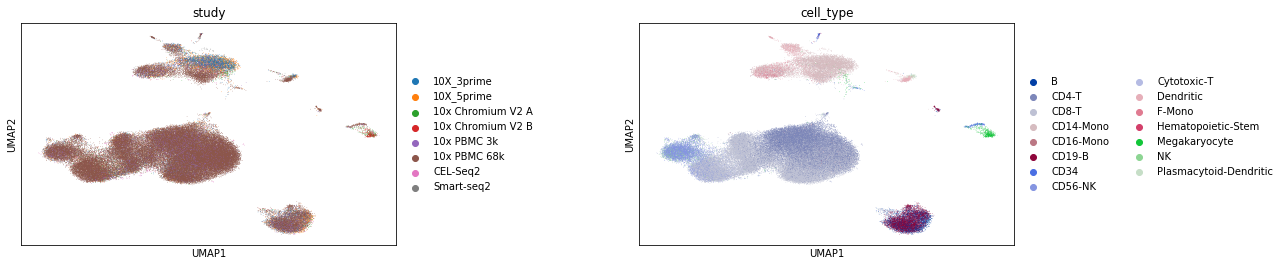

In [22]:
sc.pl.umap(latent_adata, color=[batch_key, cell_type_key], wspace=0.5)

# Performing Architecture Surgery

In [24]:
new_network = surgeon.operate(network, 
                              new_conditions=target_batches,
                              init='Xavier', 
                              freeze=True)

/home/mohsen/scnet/surgeon/models/_cvae.py:149: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1793)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 1803)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          923136      concatenate_3[0][0]              
__________

In [25]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [26]:
train_adata.shape, valid_adata.shape

((11192, 1793), (1976, 1793))

In [28]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=batch_key,
                  le=new_network.condition_encoder, 
                  n_epochs=300,
                  batch_size=32, 
                  early_stop_limit=30,
                  lr_reducer=20, 
                  n_per_epoch=0,
                  save=False, 
                  verbose=2)

Train on 11192 samples, validate on 1976 samples
Epoch 1/300
 - 3s - loss: 1.0177 - nb: 1.0177 - val_loss: 0.8140 - val_nb: 0.8140
Epoch 2/300
 - 2s - loss: 0.8827 - nb: 0.8827 - val_loss: 0.8258 - val_nb: 0.8258
Epoch 3/300
 - 2s - loss: 0.8373 - nb: 0.8373 - val_loss: 0.8156 - val_nb: 0.8156
Epoch 4/300
 - 2s - loss: 0.8125 - nb: 0.8125 - val_loss: 0.7976 - val_nb: 0.7976
Epoch 5/300
 - 2s - loss: 0.7947 - nb: 0.7947 - val_loss: 0.7846 - val_nb: 0.7846
Epoch 6/300
 - 2s - loss: 0.7837 - nb: 0.7837 - val_loss: 0.7734 - val_nb: 0.7734
Epoch 7/300
 - 2s - loss: 0.7710 - nb: 0.7710 - val_loss: 0.7550 - val_nb: 0.7550
Epoch 8/300
 - 2s - loss: 0.7638 - nb: 0.7638 - val_loss: 0.7502 - val_nb: 0.7502
Epoch 9/300
 - 2s - loss: 0.7588 - nb: 0.7588 - val_loss: 0.7583 - val_nb: 0.7583
Epoch 10/300
 - 2s - loss: 0.7545 - nb: 0.7545 - val_loss: 0.7479 - val_nb: 0.7479
Epoch 11/300
 - 2s - loss: 0.7496 - nb: 0.7496 - val_loss: 0.7508 - val_nb: 0.7508
Epoch 12/300
 - 2s - loss: 0.7442 - nb: 0.7442 

In [30]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=batch_key)

In [31]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 13168 × 20 
    obs: 'CBC', 'CellType', 'Experiment', 'Method', 'batch', 'bulk_labels', 'cell_type', 'louvain', 'method', 'n_counts', 'n_genes', 'percent_mito', 'study', 'size_factors'

In [32]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

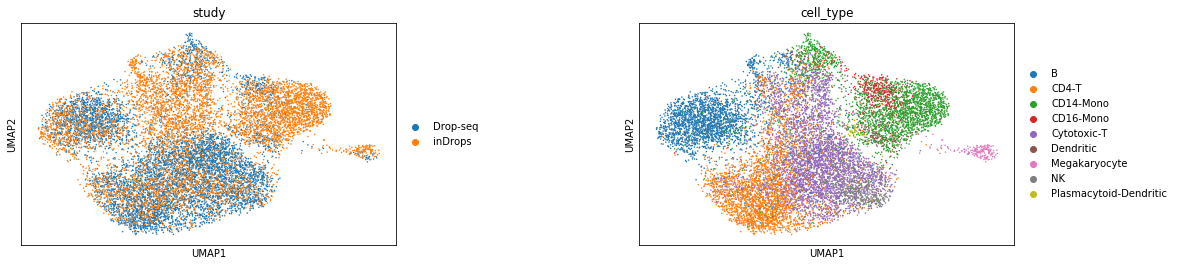

In [34]:
sc.pl.umap(latent_adata, color=[batch_key, cell_type_key], wspace=0.5)

# Performing Classification on latent projection of out-of-sample data

## Unsupervised clustering

In [35]:
sc.tl.louvain(latent_adata)

Trying to set attribute `.obs` of view, making a copy.


## Differential test

/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/scanpy/preprocessing/_utils.py:10: RuntimeWarning: Mean of empty slice.
  mean = X.mean(axis=0)
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/scanpy/preprocessing/_utils.py:16: RuntimeWarning: Mean of empty slice.
  mean_sq = np.multiply(X, X).mean(axis=0)
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:369: RuntimeWarning: invalid value encountered in true_divide
  (ns[imask] * (n_cells - ns[imask]) * (n_cells + 1) / 12))
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/scanpy/plotting/_tools/__init__.py:253: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set

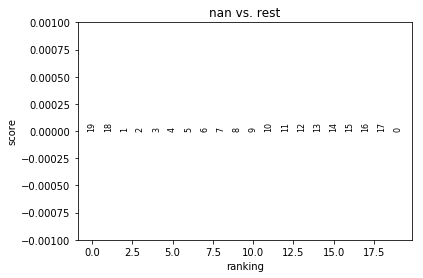

In [36]:
sc.tl.rank_genes_groups(latent_adata, 'louvain', method='wilcoxon',)
sc.pl.rank_genes_groups(latent_adata, n_genes=25, sharey=False)

In [ ]:
marker_genes = [] #TODO: has to be determined for PBMC dataset

In [ ]:
pd.DataFrame(latent_adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
result = latent_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
sc.pl.umap(latent_adata, color=['louvain', cell_type_key])

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

In [ ]:
new_cluster_names = [] # TODO: has to be determined for PBMC dataset
adata.rename_categories('louvain', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='louvain', title='annotation', frameon=False, save='.pdf')

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='louvain')

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)